In [1]:
import tensorflow as tf
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime



In [2]:


# Load CSV file with image file names and labels
csv_path = 'train/train/train.csv'  
data = pd.read_csv(csv_path)

# Path to the folder containing the images
image_folder = 'train/train/images'  

# Function to load and preprocess images
def load_and_preprocess_images(file_paths, target_size=(224, 224)):
    images = []
    for file_path in file_paths:
        image = cv2.imread(os.path.join(image_folder, file_path))
        image = cv2.resize(image, target_size)
        image = image.astype('float32') / 255.0  # Normalize pixel values
        images.append(image)
    return np.array(images)

# Load and preprocess images
images = load_and_preprocess_images(data['filename'])

# Encode labels (assuming labels are in 1, 2, 3, 4, 5, 6 format)
labels = data['label'] - 1  # Subtract 1 to convert to 0-based indices

# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

# Print shapes for verification
print("Train Images Shape:", train_images.shape)
print("Train Labels Shape:", train_labels.shape)
print("Validation Images Shape:", val_images.shape)
print("Validation Labels Shape:", val_labels.shape)


Train Images Shape: (5760, 224, 224, 3)
Train Labels Shape: (5760,)
Validation Images Shape: (1440, 224, 224, 3)
Validation Labels Shape: (1440,)


In [3]:
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [4]:
# Set checkpoint path

checkpoint_path = "models/checkpoint.ckpt"

# Create a MOdelCheckpoint callback that saves the model's weights only
checkpoint_callbck = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        save_best_only=False,
                                                        save_freq="epoch",
                                                        verbose=1)

In [5]:

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()


In [6]:
def test_prediction(model):

    # Load the test data CSV file
    test_csv_path = 'test/test/test.csv'  # Replace with the actual path
    test_data = pd.read_csv(test_csv_path)

    # Path to the folder containing test images
    test_image_folder = 'test/test/images'  # Replace with the actual path

    # Function to load and preprocess test images
    def load_and_preprocess_test_images(file_paths, target_size=(224, 224)):
        images = []
        for file_path in file_paths:
            image = cv2.imread(os.path.join(test_image_folder, file_path))
            image = cv2.resize(image, target_size)
            image = image.astype('float32') / 255.0  # Normalize pixel values
            images.append(image)
        return np.array(images)

    # Load and preprocess test images
    test_images = load_and_preprocess_test_images(test_data['filename'])



    # Enable memory debugging
    tf.debugging.experimental.enable_dump_debug_info("memory_debug")

    # Make predictions
    predictions = model.predict(test_images)

    # Disable memory debugging
    tf.debugging.experimental.disable_dump_debug_info()


    # Assign labels based on the predicted probabilities
    predicted_labels = np.argmax(predictions, axis=1)

    # Add predicted labels to the test data DataFrame
    test_data['predicted_label'] = predicted_labels + 1  # Add 1 to convert back to 1-indexed labels

    # Save the updated test data CSV file
    test_data.to_csv('Results/result.csv', index=False)  # Replace with the desired path


In [7]:
model_9 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    
    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2),
    
    tf.keras.layers.Dense(32, activation="relu"),  # Added an extra dense layer
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation="softmax")
])

model_9.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [8]:
# Train the model
history_model_9 = model_9.fit(
    train_images, train_labels,
    epochs=10,
    validation_data=(val_images, val_labels),
    callbacks = [create_tensorboard_callback(dir_name = "models",
                                             experiment_name="model_9"),
                                             checkpoint_callbck])


Saving TensorBoard log files to: models/model_9/20231203-142843
Epoch 1/10
180/180 [==============================] - ETA: 0s - loss: 2.1685 - accuracy: 0.4500
Epoch 1: saving model to models\checkpoint.ckpt
180/180 [==============================] - 610s 3s/step - loss: 2.1685 - accuracy: 0.4500 - val_loss: 1.6331 - val_accuracy: 0.2910
Epoch 2/10
180/180 [==============================] - ETA: 0s - loss: 0.8440 - accuracy: 0.6774
Epoch 2: saving model to models\checkpoint.ckpt
180/180 [==============================] - 592s 3s/step - loss: 0.8440 - accuracy: 0.6774 - val_loss: 1.4742 - val_accuracy: 0.4194
Epoch 3/10
180/180 [==============================] - ETA: 0s - loss: 0.4990 - accuracy: 0.8189
Epoch 3: saving model to models\checkpoint.ckpt
180/180 [==============================] - 591s 3s/step - loss: 0.4990 - accuracy: 0.8189 - val_loss: 1.5195 - val_accuracy: 0.5382
Epoch 4/10
180/180 [==============================] - ETA: 0s - loss: 0.3283 - accuracy: 0.8797
Epoch 4: sav

In [ ]:
# Steup input shape and base model , freezing the base model layers
input_shape = (224, 224, 3)

# Create base model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create the input layers
inputs = layers.Input(shape=input_shape, name="input_layers")

# Addin data augmentation Sequential model as layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x= base_model(x, training=False)

# pool output features of the base model
x = layers.GlobalAveragePooling2D(name= "global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make model using the inputs and outputs
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputes and outputs

model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])





In [7]:
# CVreate model 2 with data augmentation built in

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# create the input and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name= "inpute_layer")
x = data_augmentation(inputs)# augment our training images (augmentation doesn't occur on test data)
x = base_model(x, training=False) # pass augmented images to base model but keep it in inferance mode, this also insures batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(6, activation="softmax", name="output_layer")(x)
model_10 = tf.keras.Model(inputs, outputs)

# Compile the model
model_10.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])




In [ ]:
# Train the model
history_model_10 = model_10.fit(
    train_images, train_labels,
    epochs=10,
    validation_data=(val_images, val_labels),
    callbacks = [create_tensorboard_callback(dir_name = "models",
                                             experiment_name="model_10"),
                                             checkpoint_callbck])


In [7]:
# Let's make create_model() function to model from a url
def create_model(model_url, num_classes=6):
  """
  Takes a tensorflow hub URL and creates a keras sequential model with it.

  Args:
    model_url(str): A tensorflow hub feature extraction URL.
    num_classes (int): Number of output nrurons in the output layer,
    should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layers = hub.KerasLayer(model_url,
                                            trainable=False, # Freeze the already learned pattarens
                                            name= "feature_extraction_layer",
                                            input_shape=(224,224,3)) # Freeze the already learned pattarens
  # cretae our own model
  model = tf.keras.Sequential([
      feature_extractor_layers,
      layers.Dense(num_classes, activation="softmax", name = "output_layer")
  ])

  return model


In [8]:
efficientnet_url= "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [9]:
efficientnet_model = create_model(model_url= efficientnet_url,
                                  num_classes=6)

In [10]:
# compile Efficientnet model
efficientnet_model.compile(loss="sparse_categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

In [11]:
# Train the model
history_FE_model_8 = efficientnet_model.fit(
    train_images, train_labels,
    epochs=20,
    validation_data=(val_images, val_labels),
    callbacks = [create_tensorboard_callback(dir_name = "models",
                                             experiment_name="FE_model_8"),
                                             checkpoint_callbck])


Saving TensorBoard log files to: models/FE_model_8/20231203-225232
Epoch 1/20
180/180 [==============================] - ETA: 0s - loss: 0.8878 - accuracy: 0.6635
Epoch 1: saving model to models\checkpoint.ckpt
180/180 [==============================] - 130s 664ms/step - loss: 0.8878 - accuracy: 0.6635 - val_loss: 0.7011 - val_accuracy: 0.7340
Epoch 2/20
180/180 [==============================] - ETA: 0s - loss: 0.6057 - accuracy: 0.7743
Epoch 2: saving model to models\checkpoint.ckpt
180/180 [==============================] - 116s 643ms/step - loss: 0.6057 - accuracy: 0.7743 - val_loss: 0.6112 - val_accuracy: 0.7611
Epoch 3/20
180/180 [==============================] - ETA: 0s - loss: 0.5175 - accuracy: 0.8038
Epoch 3: saving model to models\checkpoint.ckpt
180/180 [==============================] - 119s 664ms/step - loss: 0.5175 - accuracy: 0.8038 - val_loss: 0.5675 - val_accuracy: 0.7792
Epoch 4/20
180/180 [==============================] - ETA: 0s - loss: 0.4599 - accuracy: 0.8259


In [12]:
efficientnet_model.save("best_FE_model_8.keras")

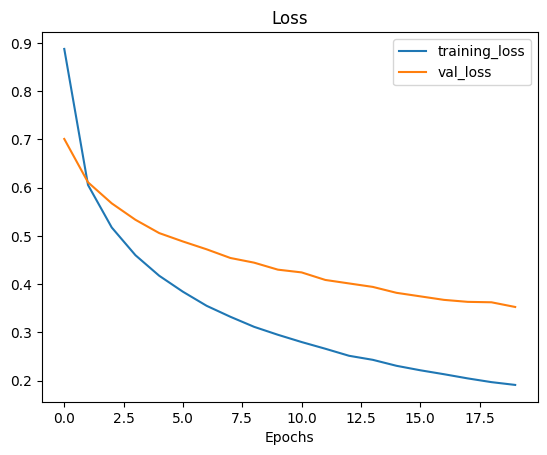

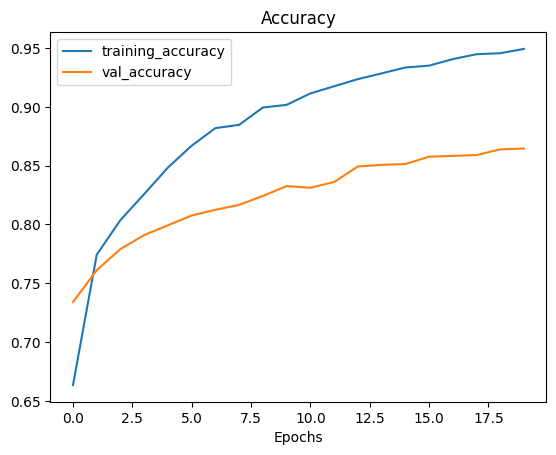

In [13]:
plot_loss_curves(history_FE_model_8)

In [14]:
test_prediction(efficientnet_model)

INFO:tensorflow:Enabled dumping callback in thread MainThread (dump root: memory_debug, tensor debug mode: NO_TENSOR)


INFO:tensorflow:Enabled dumping callback in thread MainThread (dump root: memory_debug, tensor debug mode: NO_TENSOR)


150/150 [==============================] - 60s 386ms/step
INFO:tensorflow:Disabled dumping callback in thread MainThread (dump root: memory_debug)


INFO:tensorflow:Disabled dumping callback in thread MainThread (dump root: memory_debug)
